In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
plt.rcParams['figure.figsize'] = 15, 6            #agar semua plot ukurannya sama
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# load data
data = pd.read_csv('/content/Electric_Production.csv')
print(data.head())
print('\n Data Types:')
print(data.dtypes)

       DATE  IPG2211A2N
0  1/1/1985     72.5052
1  2/1/1985     70.6720
2  3/1/1985     62.4502
3  4/1/1985     57.4714
4  5/1/1985     55.3151

 Data Types:
DATE           object
IPG2211A2N    float64
dtype: object


In [3]:
len(data) #menghitung jumlah data

397

In [5]:
#Mengubah tanggal menjadi index
con=data['DATE']
data['DATE']=pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)
#check datatype of index
data.index

DatetimeIndex(['1985-01-01', '1985-02-01', '1985-03-01', '1985-04-01',
               '1985-05-01', '1985-06-01', '1985-07-01', '1985-08-01',
               '1985-09-01', '1985-10-01',
               ...
               '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01',
               '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01',
               '2017-12-01', '2018-01-01'],
              dtype='datetime64[ns]', name='DATE', length=397, freq=None)

In [6]:
data

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151
...,...
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359


In [7]:
#convert to time series:
ts = data['IPG2211A2N']
ts.head(10)

DATE
1985-01-01    72.5052
1985-02-01    70.6720
1985-03-01    62.4502
1985-04-01    57.4714
1985-05-01    55.3151
1985-06-01    58.0904
1985-07-01    62.6202
1985-08-01    63.2485
1985-09-01    60.5846
1985-10-01    56.3154
Name: IPG2211A2N, dtype: float64

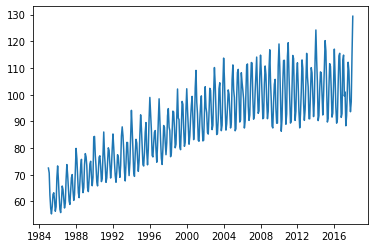

In [8]:
plt.plot(ts)

In [42]:
#Membuat fungsi untuk uji stasioneritas
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling( window=12).mean()
    rolstd = timeseries.rolling( window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='yellow', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

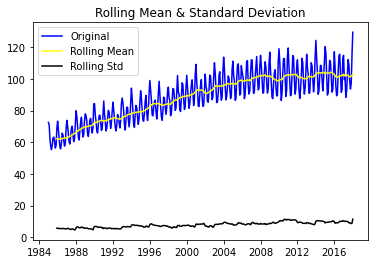

Results of Dickey-Fuller Test:
Test Statistic                  -2.256990
p-value                          0.186215
#Lags Used                      15.000000
Number of Observations Used    381.000000
Critical Value (1%)             -3.447631
Critical Value (5%)             -2.869156
Critical Value (10%)            -2.570827
dtype: float64


In [43]:
#Menguji data
test_stationarity(ts)

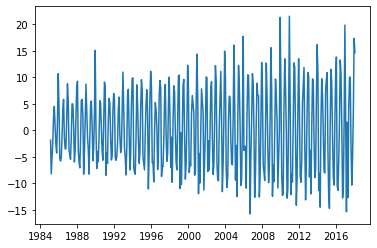

In [44]:
#Melakukan differencing pertama
ts_diff_1 = ts - ts.shift()
ts_diff_1 = ts_diff_1.dropna()
plt.plot(ts_diff_1)

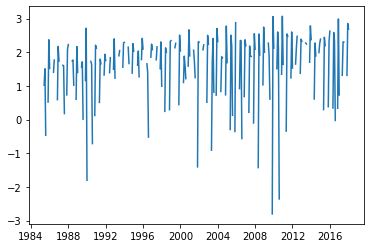

In [45]:
#Mencoba melakukan transformasi log
ts_log_dif = np.log(ts_diff_1)
plt.plot(ts_log_dif)

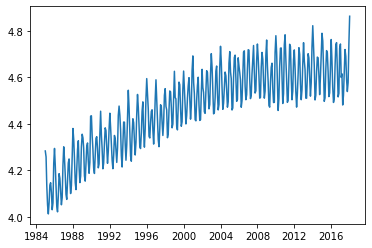

In [13]:
#Mencoba melakukan transformasi log menggunakan data awal
ts_log = np.log(ts)
plt.plot(ts_log)

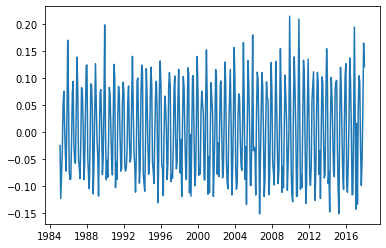

In [46]:
#Melakukan differencing setelah transform log
ts_log_1 = ts_log - ts_log.shift()
ts_log_1 = ts_log_1.dropna()
plt.plot(ts_log_1)

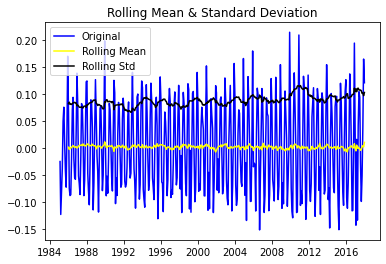

Results of Dickey-Fuller Test:
Test Statistic                -6.748333e+00
p-value                        2.995161e-09
#Lags Used                     1.400000e+01
Number of Observations Used    3.810000e+02
Critical Value (1%)           -3.447631e+00
Critical Value (5%)           -2.869156e+00
Critical Value (10%)          -2.570827e+00
dtype: float64


In [47]:
test_stationarity(ts_log_1)

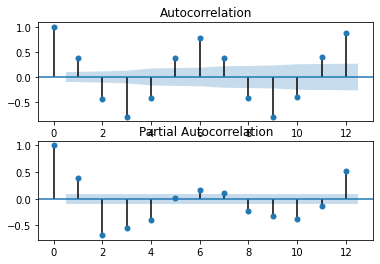

In [48]:
plt.figure()
plt.subplot(211)
plot_acf(ts_log_1, ax=plt.gca(), lags=12)
plt.subplot(212)
plot_pacf(ts_log_1, ax=plt.gca(), lags=12)
plt.show()

In [49]:
#membuat model ARIMA
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.7)               #data trainingnya 70%
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))


In [50]:
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(ts_log.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=0.203
ARIMA(0, 0, 1) RMSE=0.119
ARIMA(0, 1, 0) RMSE=0.093
ARIMA(0, 1, 1) RMSE=0.078
ARIMA(1, 0, 0) RMSE=0.091
ARIMA(1, 0, 1) RMSE=0.075
ARIMA(1, 0, 2) RMSE=0.070
ARIMA(1, 1, 0) RMSE=0.086
ARIMA(1, 1, 1) RMSE=0.086
ARIMA(2, 0, 0) RMSE=0.081
ARIMA(2, 0, 1) RMSE=0.074
ARIMA(2, 0, 2) RMSE=0.067
ARIMA(2, 1, 0) RMSE=0.062
Best ARIMA(2, 1, 0) RMSE=0.062


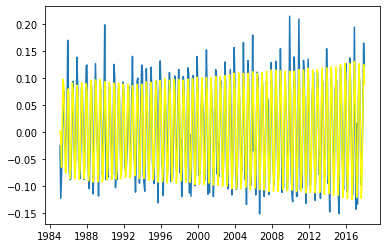

In [52]:
model_ARIMA = ARIMA(ts_log, order=(2,1,2))
results_ARIMA = model_ARIMA.fit(disp=-1)
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues,copy=True)
plt.plot(ts_log_1)             
plt.plot(predictions_ARIMA_diff, color='yellow')  #fitting dengan data yang udah difference sekali dan log

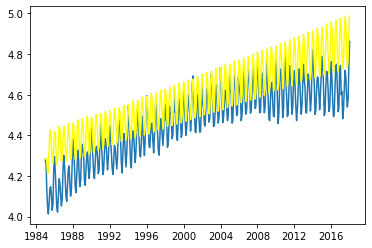

In [53]:
predictions_ARIMA_diff_cum_sum = predictions_ARIMA_diff.cumsum()                                
predictions_ARIMA_log = pd.Series(ts_log.iloc[0],index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cum_sum,fill_value=0)
plt.plot(ts_log)             
plt.plot(predictions_ARIMA_log, color='yellow') #fitting dengan data yang ditransformasi log

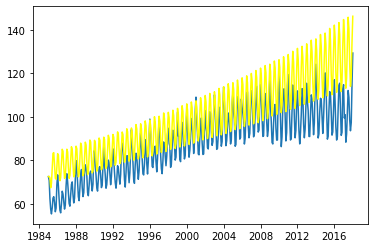

In [54]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA, color='yellow') #fitting dengan data asli

In [55]:
print(results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.IPG2211A2N   No. Observations:                  396
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 755.122
Method:                       css-mle   S.D. of innovations              0.035
Date:                Sun, 10 Apr 2022   AIC                          -1498.245
Time:                        15:42:31   BIC                          -1474.356
Sample:                    02-01-1985   HQIC                         -1488.781
                         - 01-01-2018                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0014      0.002      0.796      0.426      -0.002       0.005
ar.L1.D.IPG2211A2N     0.9993      0.001   1180.239      0.000       0.998       1.001
ar.L2.D.IPG2211A2N  

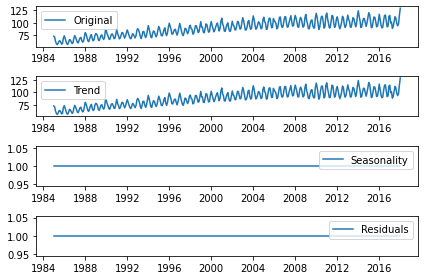

In [56]:
#KOMBINASI MODEL DENGAN SEASONAL DAN TREND
decomposition = seasonal_decompose(ts, model='multiplicative', freq=1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [57]:
train_size = int(len(ts) * 0.7)               #data trainingnya 70%
train, test = ts_log[:train_size], ts_log[train_size:]
history = [x for x in train]
# make predictions
predictions = list()
for t in range(len(test)):
		model = SARIMAX(history, order=(1,1,1), seasonal_order=(1,1,1,4))
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])

# calculate out of sample error
rmse = sqrt(mean_squared_error(test, predictions))
print(rmse)

0.07225632419620676


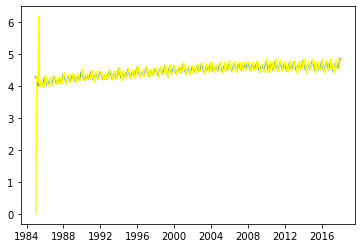

In [60]:
#membuat model SARIMA
model_sarima = SARIMAX(ts_log, order=(1,1,1), seasonal_order=(1,1,1,4))
results_SARIMA = model_sarima.fit(disp=-1)
predictions_SARIMA_diff = pd.Series(results_SARIMA.fittedvalues,copy=True)
plt.plot(ts_log)             
plt.plot(predictions_SARIMA_diff, color='yellow') #fitting dengan data log

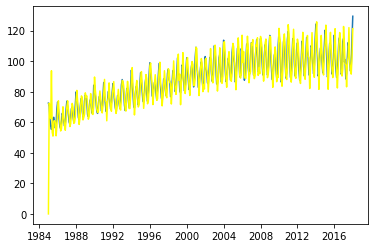

In [61]:
#SARIMA + trend untuk data asli
model_sarima_trend = SARIMAX(ts, order=(1,1,1), seasonal_order=(1,1,1,4), trend='t')
results_SARIMA_t = model_sarima_trend.fit(disp=-1)
predictions_SARIMA_diff_t = pd.Series(results_SARIMA_t.fittedvalues,copy=True)
plt.plot(ts)             
plt.plot(predictions_SARIMA_diff_t, color='yellow')

In [62]:
print(results_SARIMA_t.summary())

                                 Statespace Model Results                                
Dep. Variable:                        IPG2211A2N   No. Observations:                  397
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood               -1286.302
Date:                           Sun, 10 Apr 2022   AIC                           2584.603
Time:                                   15:46:27   BIC                           2608.431
Sample:                               01-01-1985   HQIC                          2594.047
                                    - 01-01-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       1.108e-07   8.04e-05      0.001      0.999      -0.000       0.000
ar.L1         -0.3578      0.124     -2.878

In [63]:
#membuat prediksi
#dengan model ARIMA(2,1,2)
predict_dif = results_ARIMA.predict(start=144,end=156)
predictions_dif_cum_sum = predict_dif.cumsum() #prediksi differencingnya
pred_log = [ts_log[-1]]
for i, j in enumerate(predictions_dif_cum_sum): #prediksi data lognya
  a = pred_log[i] + j
  pred_log.append(a)
#prediksi data aslinya
predict_exp = pd.Series(np.exp(pred_log[1:]), index=predict_dif.index)
print(predict_exp)

1997-01-01    138.673034
1997-02-01    144.854450
1997-03-01    138.058806
1997-04-01    123.406113
1997-05-01    113.594630
1997-06-01    115.195834
1997-07-01    125.307936
1997-08-01    132.802207
1997-09-01    127.891419
1997-10-01    114.917097
1997-11-01    106.099024
1997-12-01    107.905847
1998-01-01    117.697461
Freq: MS, dtype: float64


In [64]:
#prediksi dengan SARIMA+trend
pred_2 = results_SARIMA_t.predict(start=144,end=156)
print(pred_2)

1997-01-01    94.059955
1997-02-01    99.316833
1997-03-01    85.543136
1997-04-01    81.595613
1997-05-01    70.733535
1997-06-01    76.828440
1997-07-01    84.077948
1997-08-01    93.727932
1997-09-01    85.608094
1997-10-01    77.629102
1997-11-01    76.070804
1997-12-01    85.605283
1998-01-01    95.066331
Freq: MS, dtype: float64
